# Testing Deferred Revenue in Python
Will this be easier for everyone to use than Matlab?

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

plt.style.use('ggplot')

## Step 1: Processing Base Billings Data

In [2]:
df = pd.read_excel('../data/Creative_billings.xlsx')

In [3]:
df.sample(10)

,Day of Invoice Calender Date,Document Currency,Enterprise BU Desc,Frequency,Major Product Config Desc,Major Product Group Hier Desc,Product Config Type,Product Mgt BU,Rev Rec Category,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales ( DC ),Completed Sales
510757,2019-10-30,USD,Creative,NaN,Subscription,POINT,1Y,Pro DI,A,NaN,DEFERRED,12,458916.49,452802.49
469714,2018-11-05,USD,Creative,NaN,Royalty,NaN,NaN,Digital Publishing,NaN,NaN,RECOGNIZED,0,396861.00,396861.00
215509,2017-12-30,GBP,Creative,NaN,Subscription,NaN,1Y,Pro DI,A,NaN,DEFERRED,1,-114.02,-153.05
448381,2019-10-14,SGD,Creative,NaN,Subscription,SUITE,MTHLY,All Media,D,Y3,DEFERRED,1,692.74,502.47
440007,2019-06-12,SEK,Creative,NaN,Subscription,SUITE,MTHLY,All Media,D,Y3,DEFERRED,1,18473.00,1958.88
236523,2019-05-08,GBP,Creative,NaN,Subscription,POINT,1Y,Pro DI,D,Y3,DEFERRED,1,82586.26,107688.07
286530,2019-09-04,INR,Creative,NaN,Subscription,SUITE,1Y,Design,D,Y3,DEFERRED,1,676.00,9.43
436423,2019-04-20,SEK,Creative,NaN,Subscription,SUITE,1Y,All Media,D,NaN,DEFERRED,1,-321.97,-34.70
460107,2019-08-14,TWD,Creative,NaN,Subscription,POINT,MTHLY,Pro DI,D,Y3,DEFERRED,1,3880.00,123.40
248868,2018-06-16,GBP,Creative,NaN,Subscription,SUITE,MTHLY,All Media,D,Y3,DEFERRED,1,9674.24,12886.74


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540144 entries, 0 to 540143
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Day of Invoice Calender Date   540144 non-null  datetime64[ns]
 1   Document Currency              540144 non-null  object        
 2   Enterprise BU Desc             540144 non-null  object        
 3   Frequency                      2627 non-null    object        
 4   Major Product Config Desc      540144 non-null  object        
 5   Major Product Group Hier Desc  388802 non-null  object        
 6   Product Config Type            467105 non-null  object        
 7   Product Mgt BU                 540144 non-null  object        
 8   Rev Rec Category               480513 non-null  object        
 9   Rule For Bill Date             300532 non-null  object        
 10  Sales Type                     540144 non-null  object        
 11  

In [7]:
df['Major Product Config Desc'].value_counts()

Subscription           450543
Software as Service     37764
Full                    24468
Licensing               10569
Upgrade                  8113
Educational              5900
Royalty                  1084
Other                     747
Upgrade Plan              666
Royalty M&S               168
Licensing M&S              79
Consulting                 41
OEM Bundles                 2
Name: Major Product Config Desc, dtype: int64

In [8]:
df['Major Product Group Hier Desc'].value_counts()

POINT    263558
SUITE    125244
Name: Major Product Group Hier Desc, dtype: int64

In [9]:
df['Product Mgt BU'].value_counts()

Pro DI                  118352
Design                  112608
All Media                98084
DVA                      78309
Stock Photography        68426
Web                      41830
Elements                 21277
Digital Publishing         416
Flash Builder              374
CCE Stock                  292
Distribution/Toolbar        96
Mobile                      55
Immersive Design            25
Name: Product Mgt BU, dtype: int64

In [10]:
df['Sales Type'].value_counts()

DEFERRED       491208
RECOGNIZED      48901
NON-REV            31
PRO-SVC-INV         4
Name: Sales Type, dtype: int64

# Changing the column names early since they are inconsistent across other reports

In [27]:
df.columns

Index(['Day of Invoice Calender Date', 'curr', 'BU', 'freq', 'MPC_desc',
       'point_or_suite', 'config', 'product', 'rev_req_type', 'rebill_rule',
       'Sales Type', 'Subscription Term', 'DC_amount', 'US_amount'],
      dtype='object')

In [28]:
df.rename(index = str, columns = {'Day of Invoice Calender Date': 'date', 
                                 'Document Currency':'curr',
                                 'Enterprise BU Desc':'BU',
                                 'Frequency':'freq',
                                 'Major Product Config Desc':'MPC_desc',
                                 'Major Product Group Hier Desc':'point_or_suite',
                                 'Product Config Type': 'config',
                                 'Product Mgt BU': 'product',
                                 'Rev Rec Category': 'rev_req_type',
                                 'Rule For Bill Date': 'rebill_rule',
                                 'Completed Sales ( DC )': 'DC_amount',
                                 'Completed Sales': 'US_amount'}, inplace=True)

In [29]:
df.columns

Index(['date', 'curr', 'BU', 'freq', 'MPC_desc', 'point_or_suite', 'config',
       'product', 'rev_req_type', 'rebill_rule', 'Sales Type',
       'Subscription Term', 'DC_amount', 'US_amount'],
      dtype='object')

In [30]:
df.sample(10)

,date,curr,BU,freq,MPC_desc,point_or_suite,config,product,rev_req_type,rebill_rule,Sales Type,Subscription Term,DC_amount,US_amount
73815,2018-06-30,CHF,Creative,NaN,Full,NaN,NaN,Pro DI,NaN,NaN,RECOGNIZED,0,476.00,479.40
22744,2018-11-10,AUD,Creative,NaN,Subscription,NaN,MTHLY,Stock Photography,D,NaN,DEFERRED,1,-35.99,-26.07
494254,2018-05-24,USD,Creative,NaN,Subscription,NaN,MTHLY,Stock Photography,D,Y3,DEFERRED,1,20560.31,20560.31
461224,2020-02-09,TWD,Creative,NaN,Subscription,SUITE,1Y,All Media,D,Y3,DEFERRED,1,231530.00,7675.95
304856,2020-01-12,JPY,Creative,NaN,Subscription,POINT,1Y,Design,A,NaN,DEFERRED,12,1991520.00,0.00
257441,2019-08-22,HKD,Creative,NaN,Subscription,NaN,1Y,Stock Photography,D,Y3,DEFERRED,1,11092.00,1414.13
365232,2019-07-09,NOK,Creative,NaN,Subscription,POINT,MTHLY,Design,D,Y3,DEFERRED,1,4245.00,495.45
125605,2018-07-06,DKK,Creative,NaN,Subscription,NaN,1Y,Stock Photography,A,NaN,DEFERRED,1,220.00,34.34
284612,2020-03-25,INR,Creative,NaN,Subscription,POINT,MTHLY,Pro DI,D,Y3,DEFERRED,1,31948.96,428.48
455350,2020-01-21,TRY,Creative,NaN,Subscription,SUITE,1Y,All Media,D,Y3,DEFERRED,1,11354.65,1932.65


## Filter that removes any currency that has  < 10 transactions. 


In [15]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['curr'].value_counts()
print(vc)

USD    78095
EUR    57906
GBP    48557
JPY    47687
AUD    43923
CHF    32439
SEK    30879
NOK    28249
DKK    27260
HKD    21137
BRL    20378
RUB    19764
KRW    13546
ARS     7487
INR     7451
CLP     7059
COP     7021
TWD     6482
SGD     6268
THB     5806
PEN     5520
PHP     5296
MYR     4435
IDR     4304
ILS     1283
TRY     1046
CAD      860
SAR        5
AED        1
Name: curr, dtype: int64


In [16]:
# Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index
# filtering the dataframe to remove any of teh currencies not in our list
df = df[df['curr'].isin(a)]

## Just keeping track of the currencies we removed in our model_dict data structure

In [31]:
remove_these = vc[vc.values <= 10].index
model_dict = {'curr_removed': list(vc[remove_these].index)}
delete_curr = list(remove_these)

## The FX database does not have information on the following currencies
 - AED (United Arab Emirates Dirham)
 - BMD (Bermudan Dollar)
 - MXP (Mexican Peso)
 - TRY (Turkish Lira)

In [32]:
if 'TRY' not in model_dict:
    model_dict['curr_removed'].append('TRY')
    delete_curr.append('TRY')
    a = a.drop('TRY')
    
print('Model dictionary', model_dict)
print('Deleted Currencies', delete_curr)

KeyError: "['TRY'] not found in axis"

In [19]:
print("---Removing infrequent currencies from billings history---")
print('Total number of currencies in the base billings file: ', len(vc))
if len(model_dict['curr_removed'])==0:
    print('No currencies were removed, all contained 10 or more billings')
    print('Currencies in the base billings file')
    for item in a:
        print(a[item], end = " ")
else:
    print('\n Currencies were removed: ', len(model_dict['curr_removed']))

    for item in remove_these:
        print(item, ', ', end="")
        
    print("\n\n{} Remaining currencies: ".format(len(a)))
    for item in a:
        print(item, ', ', end="")

---Removing infrequent currencies from billings history---
Total number of currencies in the base billings file:  29

 Currencies were removed:  3
SAR , AED , 

26 Remaining currencies: 
USD , EUR , GBP , JPY , AUD , CHF , SEK , NOK , DKK , HKD , BRL , RUB , KRW , ARS , INR , CLP , COP , TWD , SGD , THB , PEN , PHP , MYR , IDR , ILS , CAD , 

# Removing any of the values that are zero

In [34]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['DC_amount']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  534823
This is the length of the dataframe after removing zeros:  534823


In [35]:
df.sample(10)

,date,curr,BU,freq,MPC_desc,point_or_suite,config,product,rev_req_type,rebill_rule,Sales Type,Subscription Term,DC_amount,US_amount
41536,2019-03-29,AUD,Creative,NaN,Subscription,POINT,1Y,Web,D,YA,DEFERRED,12,994.52,706.10
500453,2019-05-03,USD,Creative,NaN,Subscription,POINT,MTHLY,Design,D,NaN,DEFERRED,1,-2418.54,-2418.54
509617,2019-07-02,USD,Creative,NaN,Subscription,POINT,1Y,Pro DI,A,NaN,DEFERRED,1,93570.58,93570.58
117746,2019-05-11,COP,Creative,NaN,Subscription,SUITE,1Y,All Media,D,Y3,DEFERRED,1,5423399.53,1650.45
255512,2020-01-26,HKD,Creative,NaN,Subscription,NaN,1Y,Pro DI,D,Y3,DEFERRED,1,3832.00,493.06
307960,2019-06-07,JPY,Creative,NaN,Subscription,POINT,1Y,Design,D,YA,DEFERRED,12,3901130.00,35747.84
502794,2019-11-04,USD,Creative,NaN,Subscription,POINT,1Y,DVA,A,NaN,DEFERRED,1,49258.22,49258.22
171499,2020-03-10,EUR,Creative,NaN,Subscription,POINT,1Y,Design,A,NaN,DEFERRED,12,108245.39,121156.79
310199,2018-02-28,JPY,Creative,NaN,Subscription,POINT,1Y,DVA,A,NaN,DEFERRED,1,36915.00,344.77
80331,2020-03-10,CHF,Creative,NaN,Subscription,NaN,1Y,Pro DI,D,Y3,DEFERRED,1,2142.00,2252.57


## Clearing out the Non-Revenue billings from the file
 - No Idea what these are

In [36]:
df["Sales Type"].value_counts()

DEFERRED       486788
RECOGNIZED      48031
PRO-SVC-INV         4
Name: Sales Type, dtype: int64

In [37]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))


Length of the dataframe before removing non-revenue billings:  534823
Length of the dataframe after removing non-revenue billings:   534823


## Starting to group the revenue by period, industry, etc

Attempting to group by the following categories
 - currency
 - period
 - sale type
 
May need to process the data differently with the deferred billings so we will start with the recognized and then the service billings

# DOING THIS ALL IN PANDAS WITH SPLIT APPLY COMBINE on Sales Type 


In [38]:
# First split the data into three dataframes
# Recognized billings
rec = df[df['Sales Type']=='RECOGNIZED']
svc = df[df['Sales Type']=='PRO-SVC-INV']
dfr = df[df['Sales Type']=='DEFERRED']

# NOW WORKING ON THE BILLINGS

### Recognized Revenue

In [39]:
rec.sample(10)

,date,curr,BU,freq,MPC_desc,point_or_suite,config,product,rev_req_type,rebill_rule,Sales Type,Subscription Term,DC_amount,US_amount
150945,2019-09-05,EUR,Creative,NaN,Licensing,NaN,NaN,Elements,NaN,NaN,RECOGNIZED,0,1361.00,1505.54
292268,2017-12-08,JPY,Creative,NaN,Other,NaN,NaN,Elements,NaN,NaN,RECOGNIZED,0,5400.00,48.28
413059,2018-10-29,SEK,Creative,NaN,Full,NaN,NaN,Stock Photography,NaN,NaN,RECOGNIZED,0,4527.00,498.55
202379,2018-09-28,EUR,Creative,NaN,Upgrade,NaN,NaN,Elements,NaN,NaN,RECOGNIZED,0,1024.00,1199.11
478736,2019-04-18,USD,Creative,NaN,Software as Service,SUITE,NaN,All Media,NaN,NaN,RECOGNIZED,0,324.00,324.00
538904,2019-01-17,USD,Creative,ACTL,Software as Service,POINT,ONORE,Design,NaN,NaN,RECOGNIZED,0,82011.70,82011.70
392276,2018-07-18,RUB,Creative,NaN,Full,NaN,NaN,Stock Photography,NaN,NaN,RECOGNIZED,0,7731.00,124.16
465952,2018-12-04,USD,Creative,NaN,Full,NaN,NaN,Stock Photography,NaN,NaN,RECOGNIZED,0,22121.64,22121.64
467097,2019-05-19,USD,Creative,NaN,Licensing,NaN,NaN,Elements,NaN,NaN,RECOGNIZED,0,33.00,33.00
74322,2018-03-18,CHF,Creative,NaN,Full,NaN,NaN,Stock Photography,NaN,NaN,RECOGNIZED,0,786.00,828.96


In [42]:
# testing groupby object
gb_rec = rec.groupby(['curr', 'BU', 'product','date'], as_index=False).sum()

In [43]:
# the Subscription term hangs around. We are dropping that here
gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [44]:
gb_rec.sample(10)

,curr,BU,product,date,DC_amount,US_amount
13913,HKD,Creative,Stock Photography,2019-06-19,234.00,29.88
24751,USD,Creative,Elements,2019-07-09,15125.87,15125.87
14983,JPY,Creative,All Media,2020-03-01,11484.00,104.61
19083,NOK,Creative,Stock Photography,2020-02-29,756.00,80.60
1989,AUD,Creative,Stock Photography,2018-05-19,263.41,197.80
7370,DKK,Creative,Stock Photography,2019-05-07,4166.00,624.59
3266,BRL,Creative,Stock Photography,2020-01-02,64.00,15.73
14195,INR,Creative,Stock Photography,2020-01-19,1080.00,15.23
7110,DKK,Creative,Stock Photography,2018-08-02,192.00,30.10
4806,CHF,Creative,Stock Photography,2018-01-07,391.00,401.25


In [46]:
gb_rec['product'].value_counts()

Stock Photography       10550
Elements                 6842
All Media                4572
Pro DI                   3186
Design                    581
DVA                       504
Flash Builder             290
Digital Publishing        181
Web                       107
Distribution/Toolbar       74
Mobile                     27
Name: product, dtype: int64

## TESTING STOCK PHOTOGTAPHY IN THE US!
 - create df slice that is stock photography
 - create slice that is USD

In [141]:
df_US_stock = gb_rec[(gb_rec['curr']=='USD') & (gb_rec['product']=='Stock Photography')].copy()
df_test = df_US_stock.set_index('date')

In [142]:
df_US_stock['day_of_week'] = pd.DatetimeIndex(df_US_stock['date']).day

In [143]:
df_US_stock.tail(5)

,curr,BU,product,date,DC_amount,US_amount,day_of_week
26802,USD,Creative,Stock Photography,2020-03-23,28741.45,28741.45,23
26803,USD,Creative,Stock Photography,2020-03-24,30731.64,30731.64,24
26804,USD,Creative,Stock Photography,2020-03-25,13419.22,13419.22,25
26805,USD,Creative,Stock Photography,2020-03-26,35387.44,35387.44,26
26806,USD,Creative,Stock Photography,2020-03-27,25184.43,25184.43,27


Text(0.5, 0, 'Day of the Month')

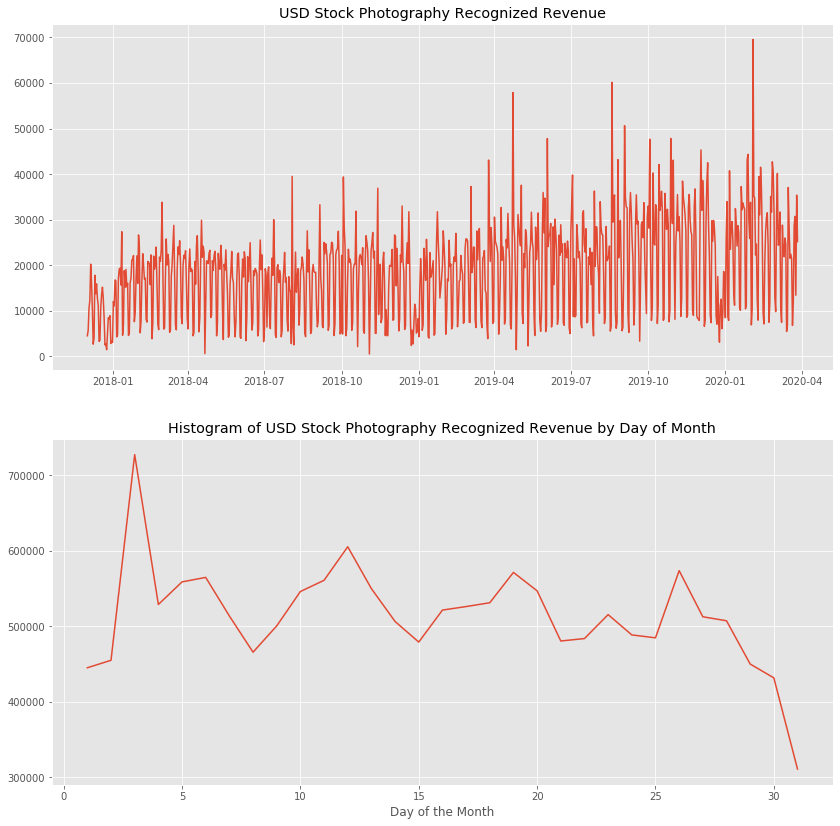

In [144]:
fig, axes = plt.subplots(2,1, figsize=(14,14))
axes[0].plot(df_US_stock['date'], df_US_stock['US_amount'])
axes[0].set_title('USD Stock Photography Recognized Revenue')

temp = df_US_stock.groupby('day_of_week')['US_amount'].sum()
axes[1].plot(temp)
axes[1].set_title('Histogram of USD Stock Photography Recognized Revenue by Day of Month')
axes[1].set_xlabel('Day of the Month')

In [175]:
def make_design_matrix(series):
    return sm.add_constant(series.reshape(-1,1))

def fit_linear_trend(series):
    X = make_design_matrix(np.arange(len(series))+1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return pd.Series(linear_trend, index=series.index)

def make_detrended_series(series, linear_trend):
    return series - linear_trend

In [176]:
def create_qtr_dummies(series):
    series_qtr = np.zeros(shape=(len(series)))
    qtr = 0
    for i in range(len(series)):
        qtr = qtr+1
        if qtr > 4:
            qtr = 1

        series_qtr[i]= qtr

    qtr_dummies = pd.get_dummies(series_qtr, drop_first=True)

    return sm.add_constant(qtr_dummies)

In [177]:
def create_daily_dummies(series):
    daily_dummies = pd.get_dummies(series, drop_first = True)
    return sm.add_constant(daily_dummies)

In [178]:
def fit_seasonal_trend(data_series, day_of_week):
    #dummies = create_qtr_dummies(series)
    dummies = create_daily_dummies(day_of_week)
    X = sm.add_constant(dummies)
    seasonal_model = sm.OLS(data_series.values, X).fit()
    seasonal_prediction = seasonal_model.predict(X)
    return seasonal_prediction

In [179]:
def create_hist_bins(series1, series2):
    x_min = np.minimum(series1.min(), series2.min())
    x_max = np.maximum(series1.max(), series2.max())
    x_step = (x_max - x_min)/10
    return np.arange(x_min, x_max, x_step)

In [180]:
def decompose_series_daily(df, name):
    # extract the series
    this_series = df[name]
    
    these_dom = df['day_of_week']

    # calculating deviation from mean for the histogram
    this_mean = np.mean(this_series)
    series_variation = this_series - this_mean
    print(np.mean(series_variation))

    # remove the linear trend with OLS
    linear_trend = fit_linear_trend(this_series)
    linear_removed = make_detrended_series(this_series, linear_trend)

    # remove seasonal component
    seasonal_trend = fit_seasonal_trend(linear_removed, these_dom)
    seasonal_removed = linear_removed - seasonal_trend.values
    model = linear_trend.values + seasonal_trend.values


    series_dict = {'name' : name,
            'raw_series': this_series,
           'series_variation': series_variation,
           'linear_trend': linear_trend,
           'linear_resids': linear_removed,
           'seasonal_trend': seasonal_trend,
           'residual': seasonal_removed,
           'model' : model}

    fig, axs = plt.subplots(5, figsize=(14,11))
    build_time_series_charts(series_dict, axs)
    fig.suptitle(name, y=1.01, fontsize='xx-large', fontweight='heavy')
    plt.show()
    return series_dict

In [181]:
def build_time_series_charts(series_dict, axs):

    axs[0].plot(series_dict['raw_series'].index, series_dict['raw_series'],
                marker='.', label = series_dict['name'])
    axs[0].plot(series_dict['raw_series'].index, series_dict['linear_trend'],
                marker='.', label = 'linear_trend')
    axs[0].legend(loc='upper left')
    axs[0].set_ylabel(series_dict['name'])
    axs[0].set_title("{} Series and Linear Trend".format(series_dict['name']))

    axs[1].hist(series_dict['raw_series'].values, bins=10, alpha=0.5, label='raw_series')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title("Histogram of {} Series".format(series_dict['name']))
    series_mean = np.mean(series_dict['raw_series'].values)
    series_std = np.std(series_dict['raw_series'].values)

    y_loc = axs[1].get_ylim()
    x_loc = axs[1].get_xlim()
    axs[1].text(x_loc[1], y_loc[1], 'Std dev: %.2f' %(round(series_std,2)), horizontalalignment='right')
    axs[1].text(x_loc[0], y_loc[1], 'Mean : %.2f' %(round(series_mean,2)), horizontalalignment='left')

    axs[2].plot(series_dict['linear_resids'].index, series_dict['linear_resids'],
                marker='.', label='{} Ex Linear Trend'.format(series_dict['name']))
    axs[2].plot(series_dict['linear_resids'].index, series_dict['seasonal_trend'],
                marker='.', label='Seasonality Estimate')
    axs[2].set_title("Linear Trend Removed and Seasonality Estimate")
    axs[2].set_ylabel(series_dict['name'])
    axs[2].legend(loc='upper left')


    axs[3].plot(series_dict['raw_series'].index, series_dict['raw_series'],
                marker='.', label='Actual {} Series'.format(series_dict['name']))
    axs[3].plot(series_dict['raw_series'].index, series_dict['model'],
                marker='.', label='Model')
    axs[3].legend(loc='upper left')
    axs[3].set_ylabel(series_dict['name'])
    axs[3].set_title("Actual {} Series vs. Final Model".format(series_dict['name']))

    #hist_bins = create_hist_bins(DSO_dict['residual'], DSO_dict['series_variation'])
    axs[4].hist(series_dict['residual'].values, alpha=0.5, label='final residuals')
    axs[4].set_ylabel('Frequency')
    axs[4].set_title("Histogram of Final Residuals")

    resids_mean = np.mean(series_dict['residual'].values)
    resids_std = np.std(series_dict['residual'].values)
    y_loc = axs[4].get_ylim()
    x_loc = axs[4].get_xlim()
    axs[4].text(x_loc[1], y_loc[1], 'Std dev: %.2f' %(round(resids_std,2)), horizontalalignment='right')
    axs[4].text(x_loc[0], y_loc[1], 'Mean : %.2f' %(round(resids_mean,2)), horizontalalignment='left')

    # testing the final model distribution versus actual
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(10))
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(10))
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(10))
    axs[3].xaxis.set_major_locator(plt.MaxNLocator(10))

    plt.tight_layout()

-5.837087601933457e-12


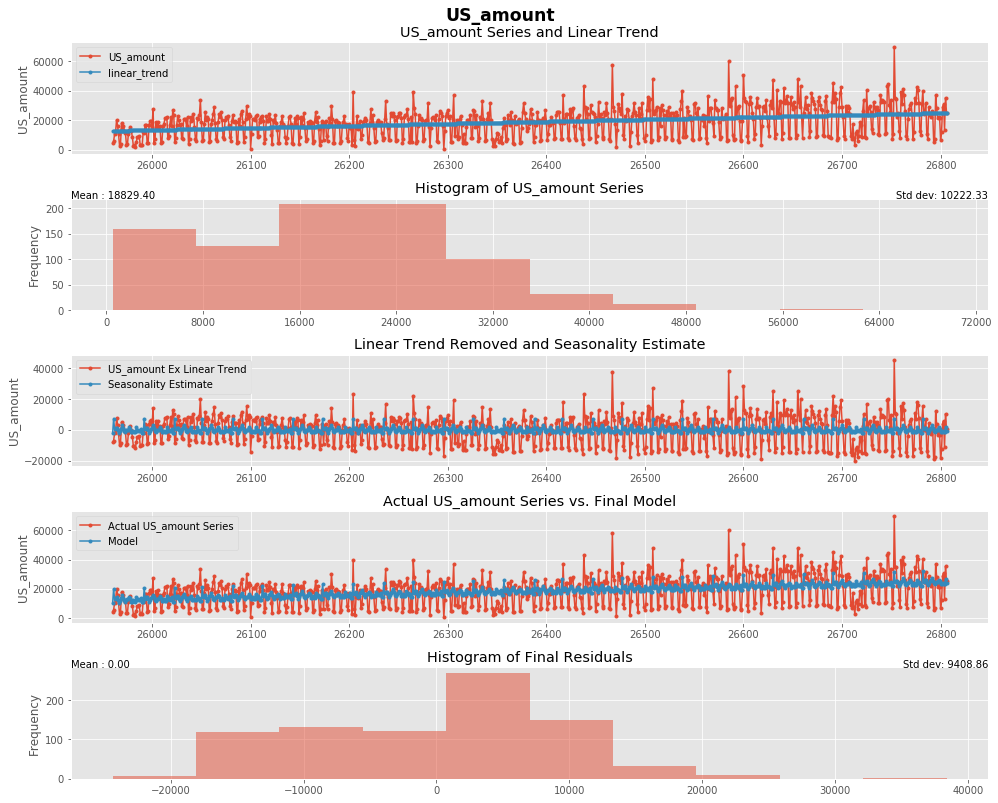

In [182]:
stock_dict = decompose_series_daily(df_US_stock, 'US_amount')

In [188]:
df_US_stock['model'] = stock_dict['model']
df_US_stock['redisual']= stock_dict['residual']

In [189]:
df_US_stock.tail(50)

,curr,BU,product,date,DC_amount,US_amount,day_of_week,model,redisual
26757,USD,Creative,Stock Photography,2020-02-07,24654.76,24654.76,7,23854.535247,800.224753
26758,USD,Creative,Stock Photography,2020-02-08,12496.35,12496.35,8,22141.817747,-9645.467747
26759,USD,Creative,Stock Photography,2020-02-09,7946.63,7946.63,9,23384.875961,-15438.245961
26760,USD,Creative,Stock Photography,2020-02-10,39458.77,39458.77,10,25011.968461,14446.801539
26761,USD,Creative,Stock Photography,2020-02-11,31065.68,31065.68,11,25542.951319,5522.728681
26762,USD,Creative,Stock Photography,2020-02-12,41517.77,41517.77,12,27129.503819,14388.266181
26763,USD,Creative,Stock Photography,2020-02-13,37035.87,37035.87,13,25147.426676,11888.443324
26764,USD,Creative,Stock Photography,2020-02-14,26198.73,26198.73,14,23594.177033,2604.552967
26765,USD,Creative,Stock Photography,2020-02-15,9567.86,9567.86,15,22619.530961,-13051.670961
26766,USD,Creative,Stock Photography,2020-02-16,7125.38,7125.38,16,24133.672747,-17008.292747


In [192]:
sum(df_US_stock['redisual'].loc[26778:])

-72361.07569720058

In [135]:
this_series = df_US_stock['US_amount']

In [139]:
df_test = df_US_stock.set_index('date')

In [140]:
df_test.head(10)

,curr,BU,product,DC_amount,US_amount,day_of_week
date,,,,,,
2017-12-02,USD,Creative,Stock Photography,4521.31,4521.31,2
2017-12-03,USD,Creative,Stock Photography,5695.87,5695.87,3
2017-12-04,USD,Creative,Stock Photography,10619.42,10619.42,4
2017-12-05,USD,Creative,Stock Photography,12307.25,12307.25,5
2017-12-06,USD,Creative,Stock Photography,20239.47,20239.47,6
2017-12-07,USD,Creative,Stock Photography,16176.74,16176.74,7
2017-12-08,USD,Creative,Stock Photography,10353.14,10353.14,8
2017-12-09,USD,Creative,Stock Photography,2682.08,2682.08,9
2017-12-10,USD,Creative,Stock Photography,4037.39,4037.39,10


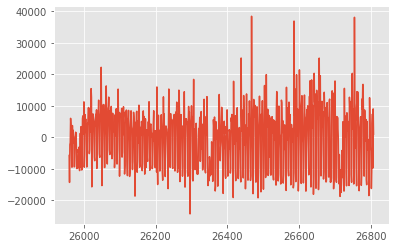

In [187]:
plt.plot(stock_dict['residual'])


## Now doing this for the service billings

In [ ]:
# testing groupby object
gb_svc = svc.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [ ]:
gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)
gb_svc.head(5)

# NOW WORKING ON DEFERRED BILLINGS

## Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months

In [ ]:
# filter out the type B first then do a group_by
dfr_b = dfr[dfr['rev_req_type']=='B']

In [ ]:
gb_b = dfr_b.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [ ]:
gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [ ]:
gb_b.head(10)

In [ ]:
print('length of deferred billings : ', len(dfr))
print('length of the type B billings: ', len(dfr_b))

## Now Type A Billings
These billings are on a billing plan. The product config tells us how long before they renew

 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)
 

In [ ]:
# filtering just the type A billings
dfr_a = dfr[dfr['rev_req_type']=='A']

In [ ]:
gb_a = dfr_a.groupby(['curr', 'BU', 'period',
                     'config'], as_index=False).sum()
gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [ ]:
gb_a.sample(10)

In [ ]:
gb_a['config'].value_counts()

### Below is just a check to see how large the billing types are across all periods

In [ ]:
gb_a_config = gb_a.groupby(['config'], as_index=False).sum()
gb_a_config

### These 'OCONS', 'ONORE' and 'OUNIV' data types are not actual product config IDs so we have to get them from a different data file. We are excluding these types below.

In [ ]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
test1 = gb_a[gb_a['config'].isin(config_list)]


In [ ]:
test1.sample(5)

## For now, lets just split this into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M


In [ ]:
gb_a_1Y = test1[test1['config']=='1Y']
gb_a_2Y = test1[test1['config']=='2Y']
gb_a_3Y = test1[test1['config']=='3Y']
gb_a_1M = test1[test1['config']=='MTHLY']

In [ ]:
print('this is the lenght of type A 1M billings: ', len(gb_a_1M))
print('this is the lenght of type A 1Y billings: ', len(gb_a_1Y))
print('this is the lenght of type A 2Y billings: ', len(gb_a_2Y))
print('this is the lenght of type A 3Y billings: ', len(gb_a_3Y))

# TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly [Y1, Y2, Y3, Y5]
 - Quarterly [YQ]
 - Every 4 months [YT]
 - Semi-annual [YH]
 - Annual [YA, YC]
 - Every 2 years - [Y4]
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [ ]:
# for now just do a groupby on the type
# filtering just the type A billings
dfr_d = dfr[dfr['rev_req_type']=='D']

In [ ]:
gb_d = dfr_d.groupby(['curr', 'BU', 'period',
                     'rebill_rule'], as_index=False).sum()
gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [ ]:
gb_d_mthly = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_d_qtrly = gb_d[gb_d['rebill_rule']=='YQ']
gb_d_four_mths = gb_d[gb_d['rebill_rule']=='YT']
gb_d_semi_ann = gb_d[gb_d['rebill_rule']=='YH']
gb_d_annual = gb_d[gb_d['rebill_rule'].isin(['YA', 'YC'])]
gb_d_two_yrs = gb_d[gb_d['rebill_rule']=='Y4']

In [ ]:
gb_d['rebill_rule'].value_counts()

### Note: There is one type D billings that is listed as 'BT' I don't know what this means, but it was a $180 EUR payment from January 2017, so we will ignore

In [ ]:
what_is_YT = gb_d[gb_d['rebill_rule']=='YT']
what_is_YT.head(10)

## Note: There are only 8 payments (back from 2017) that paid on a 4 month basis. 
We will ignore these as well.

In [ ]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of four months', len(gb_d_four_mths))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))

## NOW WE NEED TO BUILD A DATAFRAME THAT INTEGRATES THIS DATA

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

In [ ]:
# We need to do it this way when we get to a .py file!
list_df = [gb_rec, gb_svc, gb_b,
        gb_a_1M,    gb_a_1Y,    gb_a_2Y,       gb_a_3Y, 
        gb_d_mthly, gb_d_qtrly, gb_d_semi_ann, gb_d_annual, gb_d_two_yrs]

list_columns = ['recognized', 'service', 'deferred_B', 
    'deferred_1M_a', 'deferred_1Y_a', 'deferred_2Y_a', 'deferred_3Y_a',
    'deferred_1M_d', 'deferred_3M_d', 'deferred_6M_d', 'deferred_1Y_d', 'deferred_2Y_d']


In [ ]:
def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'DC_amount': new_column}, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged

In [ ]:
def merge_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        print('This is i:', i)
        #print("This is the df: ", df.head())
        print('referencing the column: ', list_columns[i])

        if i==0:
            df_merged = list_df[0]
            df_merged.rename(index=str, columns={'amount': list_columns[i]}, inplace=True)
        else:
            df_merged = merge_new_dataframe(df_merged, df, list_columns[i])

    return df_merged
    

In [ ]:
df = merge_all_dataframes(list_df, list_columns)

In [ ]:
df.columns

In [ ]:
def clean_df_columns(df):
    
    # clean up NaNs before adding 
    df = df.fillna(value=0)
    
    # Monthly
    df['deferred_1M'] = df['deferred_1M_a']+df['deferred_1M_d']
    df.drop(labels=['deferred_1M_a', 'deferred_1M_d'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y'] = df['deferred_1Y_a']+df['deferred_1Y_d']
    df.drop(labels=['deferred_1Y_a', 'deferred_1Y_d'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y'] = df['deferred_2Y_a']+df['deferred_2Y_d']
    df.drop(labels=['deferred_2Y_a', 'deferred_2Y_d'], axis=1, inplace=True)
    
    # renaming 3Y, 3M and 6M
    df.rename(index=str, columns = {'deferred_3Y_a':'deferred_3Y', 'deferred_3M_d':'deferred_3M', 
                               'deferred_6M_d': 'deferred_6M'}, inplace=True)

    #cleaning up the longer column names
    df.rename(index=str, columns = {'curr': 'curr',
                               'BU':'BU',
                               'period':'period'}, inplace=True)
    
    return df

In [ ]:
df = clean_df_columns(df)

In [ ]:
df.sample(10)

In [ ]:
# Make this a function to be cleaned up somehow
del dfr
del dfr_a
del dfr_b
del dfr_d
del gb_a
del gb_a_1M
del gb_a_1Y
del gb_a_2Y
del gb_a_3Y
del gb_b, 
del gb_d
del gb_svc, gb_rec, gb_d_two_yrs
del gb_d_four_mths, gb_d_qtrly, gb_d_semi_ann


# Now working on the ZCC billings

These billings are type D billings that did not populate the rebill_rule field of the database.

They have a 'sales document type' = 'ZCC"

The billings themselves are being created from a tableau report that looks for additions to the deferred revenue waterfall based on billings of type D and have a sales document type of ZCC

In [ ]:
whos

In [ ]:
df.sample(10)

# TO BE DONE:

1. Clean up the type F billings (at least check to see if they are necessary)
2. Make a function to delete all intermediate dataframes
3. Add type A no config function
4. Add type D ZCC billings

5. Work on the forecast part of this

6. Load up FX rates

In [ ]:
# Adobe financial calendar
df_cal = pd.read_excel('../data/old/ADOBE_FINANCIAL_CALENDAR.xlsx', 'ADBE_cal')

In [ ]:
df_cal.head()

## Working on Type A billings with no configuration

 - this is included in the all_billings_inputs file on the 'type_A_no_config' sheet

## ZCC Billings have been included in the base billings file

In [ ]:
df_ZCC = pd.read_excel('../data/all_billings_inputs.xlsx', sheet_name='type_A_no_config')

In [ ]:

# clean up NaNs before adding 
test_merge = test_merge.fillna(value=0)

# Monthly
test_merge['deferred_1M'] = test_merge['deferred_1M_x']+test_merge['deferred_1M_y']
test_merge.drop(labels=['deferred_1M_x', 'deferred_1M_x'], axis=1, inplace=True)

# Quarterly
test_merge['deferred_3M'] = test_merge['deferred_3M_x']+test_merge['deferred_3M_y']
test_merge.drop(labels=['deferred_3M_x', 'deferred_3M_y'], axis=1, inplace=True)

# Semi-Annual
test_merge['deferred_6M'] = test_merge['deferred_6M_x']+test_merge['deferred_6M_y']
test_merge.drop(labels=['deferred_6M_x', 'deferred_6M_y'], axis=1, inplace=True)

# Annual
test_merge['deferred_1Y'] = test_merge['deferred_1Y_x']+test_merge['deferred_1Y_y']
test_merge.drop(labels=['deferred_1Y_x', 'deferred_1Y_y'], axis=1, inplace=True)

# 2-Years
test_merge['deferred_2Y'] = test_merge['deferred_2Y_x']+test_merge['deferred_2Y_y']
test_merge.drop(labels=['deferred_2Y_x', 'deferred_2Y_y'], axis=1, inplace=True)





In [ ]:
test_merge.columns

In [ ]:
test_merge.sample(20)

In [ ]:
## Looks like the type ZCC billings are complete

In [ ]:
# renaming the main dataframe as df
df = test_merge.copy()

# Type A No Config Type Billings

This file contains type A billings that have a revenue contract start date and end date. We need to map these into the terms of our dataframe.

### Steps:
1. Rename the columns
2. This file has entries for pennies. Need to clear out anything less than $10 in absolute value
3. Determine the length of time between start date and end date
4. Group this dataframe by currency, period and BU
5. Merge this final dataframe with the larger dataframe

## NOTE: This file contains two different start date and end date columns. We need to look at all of them

In [ ]:
df_A = pd.read_excel('../data/old/type_A_no_config.xlsx', 'DC')

In [ ]:
df_A.sample(10)

In [ ]:
df_A.columns

In [ ]:
df_A.rename(index=str, columns={'Document Currency':'currency', 
                               'Enterprise Bu':'BU',
                               'Invoicing Fiscal Year-Period Desc':'period',
                               'Rev Rec Contract End Date Hdr':'end_date_1',
                               'Rev Rec Contract End Date Item':'end_date_2',
                               'Rev Rec Contract Start Date Hdr': 'start_date_1',
                               'Rev Rec Contract Start Date Item': 'start_date_2',
                               'Completed Sales Doc Currency':'amount'}, inplace=True)

df_A.drop(columns='Product Configtype ID', inplace=True)

In [ ]:
df_A.columns

### Dealing with the duplicate dates by taking a max

In [ ]:
df_A.head()

In [ ]:
df_A['start_date_str'] = df_A[['start_date_1','start_date_2']].max(axis=1).astype(int).astype(str)
df_A['end_date_str'] = df_A[['end_date_1','end_date_2']].max(axis=1).astype(int).astype(str)

In [ ]:
df_A.sample(10)

In [ ]:
df_A['start_date'] = pd.to_datetime(df_A['start_date_str'])
df_A['end_date'] = pd.to_datetime(df_A['end_date_str'])

In [ ]:
df_A.drop(labels=['end_date_1', 'end_date_2', 'start_date_1', 'start_date_2',
                  'start_date_str', 'end_date_str'], axis=1, inplace=True)

In [ ]:
df_A['month_interval']=(df_A['end_date']-df_A['start_date'])

In [ ]:
df_A.sample(10)

In [ ]:
df_A['months']= (df_A['month_interval']/ np.timedelta64(1,'M')).round(0)

### Now I need to map the months into the different integers in my dataframe


In [ ]:
list_rebills = [1, 3, 6, 12, 24, 36]
temp_rebill = np.zeros_like(df_A['months'])
for i in range(len(df_A)):
    temp_rebill[i] = min(list_rebills, key=lambda x:abs(x-df_A['months'][i]))
df_A['rebill_months']=temp_rebill


In [ ]:
df_A.sample(10)

In [ ]:
plt.scatter(df_A['months'], df_A['rebill_months'])

## Grouping the dataframe by rebill_months

In [ ]:
# drop what we dont need
df_A.drop(columns = ['start_date', 'end_date', 'month_interval', 'months'], axis=1, inplace=True)

In [ ]:
df_A.head()

In [ ]:
#gb_A = df+A.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [ ]:
#medals = df.pivot_table('no of medals', ['Year', 'Country'], 'medal')
temp = df_A.pivot_table('amount', ['currency', 'BU', 'period'], 'rebill_months')

In [ ]:
temp

In [ ]:
temp.columns[5]

In [ ]:
temp.fillna(0)

In [ ]:
temp.rename(index=str, columns = {''})

In [ ]:
whos